<a href="https://colab.research.google.com/github/Yuribsr/MVP---Sprint-Machine-Learning-Analytics/blob/main/MVP_G%C3%AAneroFilmes_Classifica%C3%A7%C3%A3o_Yuri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP — Definição do gênero do filme**

**Autor:** _YURI BARBOSA DOS SANTOS RIBEIRO_  

**Data:** 27/08/2025

**Matrícula:** 4052025001302


**Dataset**: [Movie Genre Classification](https://www.kaggle.com/datasets/therohithanand/movie-genre-classification)

## 1. Escopo, objetivo e definição do problema



**Contexto e objetivo**: Classificar filmes em seu gênero principal (ex.: Action, Drama, Comedy, Horror…) a partir do texto (sinopse/overview).

**Tipo de tarefa**: Classificação multiclasse (uma classe por filme).

**Área de aplicação**: NLP (Processamento de Linguagem Natural) em dados textuais.

**Valor para o negócio/usuário**: organização de catálogo, buscas e recomendações mais precisas, curadoria e insights de marketing.

## 2. Reprodutibilidade e ambiente

In [37]:
import sys, random, os, re, io, time  # utilidades do Python
import numpy as np                    # computação numérica
import pandas as pd                   # manipulação de dados tabulares
import matplotlib.pyplot as plt       # gráficos
import seaborn as sns                 # gráficos (estética)
import tensorflow as tf
import platform, sklearn
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score  # divisão/validação
from sklearn.pipeline import Pipeline                                                                 # pipeline para pré-processamento + modelo
from sklearn.feature_extraction.text import TfidfVectorizer                                           # transformação de texto em vetores
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             f1_score, top_k_accuracy_score)                             # métricas
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression                                                   # modelo baseline forte em texto
from sklearn.svm import LinearSVC                                                                     # SVM linear (muito bom para texto)
from sklearn.naive_bayes import MultinomialNB                                                         # Naive Bayes multinomial (rápido/baseline)
from sklearn.ensemble import RandomForestClassifier                                                   # comparação (menos indicado para texto esparso)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, callbacks, optimizers

SEED = 42                     # define uma semente fixa (reprodutibilidade)
random.seed(SEED)             # fixa aleatoriedade do Python
np.random.seed(SEED)          # fixa aleatoriedade do NumPy

print("Python:", sys.version.split()[0]) # Mostra a versão do Python que está sendo usada.
print("Seed global:", SEED)              # Mostra no console o valor armazenado na variável

Python: 3.12.11
Seed global: 42


Foram importadas as bibliotecas necessárias para o projeto e também definida uma semente global para garantir a reprodutibilidade dos resultados aleatórios. A saída mostra a versão do Python e a semente global definida.

# 3. Dados: carga, entendimento e qualidade

In [16]:
# importa o dataset direto do kaggle
import kagglehub

path = kagglehub.dataset_download("therohithanand/movie-genre-classification")

print("Path to dataset files:", path)
print(os.listdir(path))

# Define o df_raw como o dataset solicitado
df_raw = pd.read_csv(path + '/movie_genre_classification_final.csv')
df_raw.head()

Using Colab cache for faster access to the 'movie-genre-classification' dataset.
Path to dataset files: /kaggle/input/movie-genre-classification
['movie_genre_classification_final.csv']


,Title,Year,Director,Duration,Rating,Votes,Description,Language,Country,Budget_USD,BoxOffice_USD,Genre,Production_Company,Content_Rating,Lead_Actor,Num_Awards,Critic_Reviews
0,Winds of Fate 4,1980,R. Lee,167,4.1,182425,A touching love story with heartwarming moments.,Spanish,China,39979615,179936008,Romance,DreamWorks,R,Kangana Ranaut,8,229
1,Firestorm 11,2014,S. Chen,166,4.1,449351,A fast-paced thriller with intense action scenes.,Korean,China,116404774,802121619,Action,Netflix,R,Kangana Ranaut,20,466
2,Silent Echo 2,2016,A. Khan,170,4.1,363328,A fast-paced thriller with intense action scenes.,Korean,Japan,166261330,225526871,Action,Pixar,PG,Amitabh Bachchan,16,539
3,City Lights 4,1982,L. Zhang,170,9.9,62371,An emotional journey exploring complex charact...,Japanese,Japan,28861315,69813738,Drama,Netflix,NC-17,Natalie Portman,15,606
4,Broken Truth 1,1990,L. Zhang,91,5.3,4600,An imaginative world filled with magic and won...,Korean,USA,43890403,375136716,Fantasy,Studio Ghibli,PG,Chris Evans,6,330


In [17]:
# Verificações iniciais
display(df_raw.sample(5))
print("\nFormato:", df_raw.shape)
print("\nTipos:")
print(df_raw.dtypes)
print("\nValores ausentes por coluna:")
print(df_raw.isna().sum())

,Title,Year,Director,Duration,Rating,Votes,Description,Language,Country,Budget_USD,BoxOffice_USD,Genre,Production_Company,Content_Rating,Lead_Actor,Num_Awards,Critic_Reviews
33553,Lost World 4,2001,R. Lee,169,7.0,189120,A spine-chilling tale that evokes fear and dread.,English,USA,101281321,200330529,Horror,Paramount Pictures,NC-17,Leonardo DiCaprio,17,500
9427,Winds of Fate 13,1987,D. Patel,139,5.9,188728,A suspenseful plot filled with unexpected twists.,Mandarin,France,62714598,488839661,Thriller,Universal Pictures,NC-17,Shah Rukh Khan,15,683
199,City Lights 3,2000,R. Lee,176,5.9,365793,A fast-paced thriller with intense action scenes.,Mandarin,South Korea,189863209,428612829,Action,Studio Ghibli,PG-13,Leonardo DiCaprio,10,390
12447,Ocean Call 7,1998,J. Smith,139,8.4,462831,A suspenseful plot filled with unexpected twists.,Mandarin,USA,101281321,802121619,Thriller,Amazon Studios,PG-13,Natalie Portman,3,516
39489,Ocean Call 3,1996,P. Adams,119,5.5,38494,A touching love story with heartwarming moments.,English,UK,28861315,765377261,Romance,Paramount Pictures,R,Shah Rukh Khan,17,922



Formato: (50000, 17)

Tipos:
Title                  object
Year                    int64
Director               object
Duration                int64
Rating                float64
Votes                   int64
Description            object
Language               object
Country                object
Budget_USD              int64
BoxOffice_USD           int64
Genre                  object
Production_Company     object
Content_Rating         object
Lead_Actor             object
Num_Awards              int64
Critic_Reviews          int64
dtype: object

Valores ausentes por coluna:
Title                 0
Year                  0
Director              0
Duration              0
Rating                0
Votes                 0
Description           0
Language              0
Country               0
Budget_USD            0
BoxOffice_USD         0
Genre                 0
Production_Company    0
Content_Rating        0
Lead_Actor            0
Num_Awards            0
Critic_Reviews        0
dtype: i

O dataset possui 50.000 linhas (filmes) e 17 colunas (atributos), com dados object para texto, int64 para inteiros e float64 para números decimais.

### 3.1 Análise exploratória resumida (EDA)

/tmp/ipython-input-723845018.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  gráfico = sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")


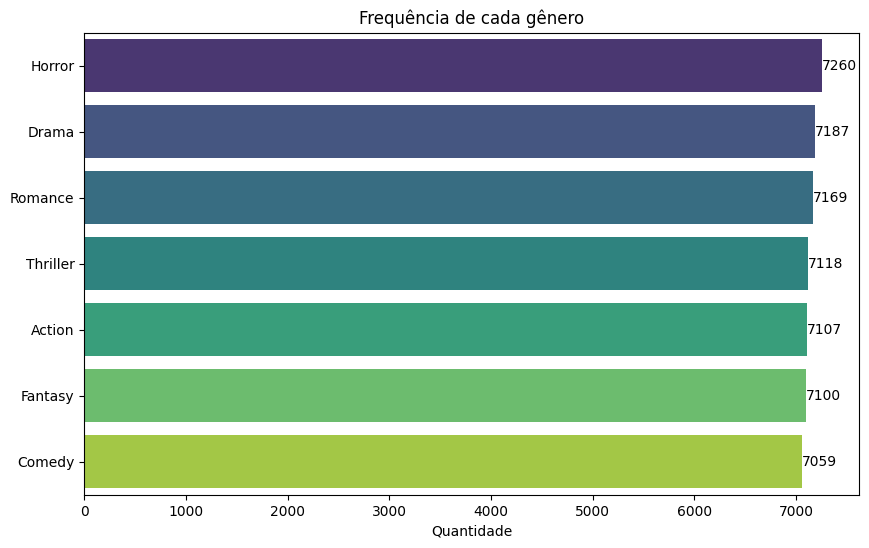

In [18]:
# Conta quantas vezes cada gênero aparece
genre_counts = df_raw["Genre"].value_counts()

# Plota gráfico de barras horizontal
plt.figure(figsize=(10,6))
# Use the genre_counts Series directly for plotting and labeling
gráfico = sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")

# Adiciona os valores em cima de cada barra
for index, value in enumerate(genre_counts.values):
    gráfico.text(value, index, str(value), ha='left', va='center', fontsize=10)

# Plota o gráfico
plt.title("Frequência de cada gênero")
plt.xlabel("Quantidade")
plt.ylabel("")
plt.show()

O gráfico mostra a distribuição dos gêneros no dataset, o que nos permite observar quais gêneros são mais ou menos frequentes. Neste caso, as barras parecem ter comprimentos semelhantes, o que indica uma distribuição relativamente balanceada entre os gêneros mais comuns.

# 4. Definição do target, variáveis e divisão dos dados

In [19]:
# Selecionando o tipo de problema: 'classificacao'
PROBLEM_TYPE = "classificacao"

# Definindo features e target conforme o problema
PROBLEM_TYPE == "classificacao"
target = "Genre"
features = [c for c in df_raw.columns if c not in [target, "timestamp"]]

print("PROBLEM_TYPE:", PROBLEM_TYPE)
print("Target:", target)
print("N features:", len(features))

# Divisão dos dados
X = df_raw[features].copy()
y = df_raw[target].copy()
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=SEED, stratify=y
  if PROBLEM_TYPE=="classificacao"
  else None
    )
print("Treino:", X_train.shape, "| Teste:", X_test.shape)

PROBLEM_TYPE: classificacao
Target: Genre
N features: 16
Treino: (40000, 16) | Teste: (10000, 16)


O conjunto de treino tem 40.000 linhas e o conjunto de teste tem 10.000 linhas, onde cada conjunto tem 16 colunas de features.

A divisão entre teste e treino foi de 80% para treino e 20% para teste.

# 5. Tratamento de dados e Pipeline de pré-processamento

In [20]:
# Faz uma cópia do dataframe original para não alterar df_raw diretamente
df= df_raw.copy()

# Converte todos os nomes de colunas para minúsculas e remove espaços extras
df.columns = [c.strip().lower() for c in df.columns]

# Lista de possíveis nomes para a coluna de gêneros
genre_candidates = ["genres", "genre", "genre_list", "primary_genre"]

# Inicializa a variável que irá guardar o nome da coluna encontrada
GENRE_COL = None

# Percorre as opções até encontrar qual coluna existe no dataset
for c in genre_candidates:                 # percorre, na ordem, cada nome possível de coluna de gêneros
    if c in df.columns:       # verifica se esse nome existe nas colunas do dataset
        GENRE_COL = c               # se existir, guarda esse nome como a coluna de gêneros que deve usar
        break                              # sai do loop imediatamente (pega apenas a primeira correspondência)

# Se não encontrar nenhuma das colunas, gera erro
assert GENRE_COL is not None, f"Não encontrei coluna de gêneros entre: {genre_candidates}"

# Cria uma nova coluna 'primary_genre' com os valores de gênero
# Converte para string e aplica strip() para remover espaços extras
df["primary_genre"] = df[GENRE_COL].astype(str).str.strip()

# Lista de possíveis nomes para a coluna de texto (sinopse/descrição do filme)
text_candidates = ["overview", "plot", "description", "storyline", "synopsis"]

# Inicializa variável para guardar o nome da coluna de texto encontrada
TEXT_COL = None

# Procura qual dessas colunas existe no dataset
for c in text_candidates:                 # percorre, na ordem, cada nome possível de coluna de texto
    if c in df.columns:      # verifica se esse nome existe nas colunas do dataset
        TEXT_COL = c               # se existir, guarda esse nome como a coluna de texto que deve usar
        break

# Se não encontrar nenhuma coluna de texto, gera erro
assert TEXT_COL is not None, f"Não encontrei coluna de texto entre: {text_candidates}"


# Função de limpeza básica para remover tags HTML
def basic_clean(s: str) -> str:
    s = str(s)                                # garante que a entrada seja string
    s = re.sub(r"<br\\s*/?>", " ", s)         # remove quebras de linha <br/>
    s = re.sub(r"<.*?>", " ", s)              # remove qualquer outra tag <...>
    return s.strip()                          # remove espaços extras no início/fim

# Aplica a limpeza de texto na coluna escolhida (sinopse/descrição)
df[TEXT_COL] = df[TEXT_COL].map(basic_clean)

# Remove linhas que tenham valores ausentes no texto ou no gênero
# e reseta os índices após a filtragem
df = df.dropna(subset=[TEXT_COL, "primary_genre"]).reset_index(drop=True)


# Mostra o shape final do dataset após os filtros
print("Shape pós-target", df.shape)

# Exibe as 3 primeiras linhas com as colunas de texto e gênero
display(df[[TEXT_COL, "primary_genre"]].head())

Shape pós-target (50000, 18)


,description,primary_genre
0,A touching love story with heartwarming moments.,Romance
1,A fast-paced thriller with intense action scenes.,Action
2,A fast-paced thriller with intense action scenes.,Action
3,An emotional journey exploring complex charact...,Drama
4,An imaginative world filled with magic and won...,Fantasy


O número de colunas aumentou para 18 devido à adição da coluna primary_genre, porém o número de linhas continuou 50.000, pois não foram encontradas linhas com valores ausentes nas colunas de texto ou gênero para serem removidas.

In [21]:
N_TOP = 10  # focar nos n gêneros mais frequentes para estabilizar o primeiro experimento

#Conta quantas vezes cada gênero aparece na coluna 'primary_genre', seleciona apenas os n primeiros, pega os nomes dessas classes e transforma em uma lista
top_genres = df['primary_genre'].value_counts().head(N_TOP).index.tolist()

# Filtra o dataset original para manter apenas as linhas onde o gênero está na lista dos n mais comuns. Depois, reseta o índice para evitar números de linha “pulados”.
df_top = df[df['primary_genre'].isin(top_genres)].reset_index(drop=True)

X = df_top[TEXT_COL]                  # Define X como a variável de entrada (features): os textos do resumo ou sinopse armazenados na coluna indicada por TEXT_COL.
y = df_top['primary_genre']           # Define y como a variável alvo (target): o gênero principal do filme.

preproc_only = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,               # converte todo texto para minúsculo
        stop_words='english',         # remove palavras muito comuns (stopwords)
        ngram_range=(1,2),            # usa palavras isoladas (1-gram) e pares de palavras (2-grams)
        max_features=200_000          # considera até 200 mil termos/frequências
    ))
])

print(f"Após filtrar para os {N_TOP} gêneros mais frequentes, "
      f"restaram {df_top.shape[0]} amostras.\n")
print("Distribuição dos gêneros no dataset filtrado:")
print(df_top['primary_genre'].value_counts())



Após filtrar para os 10 gêneros mais frequentes, restaram 50000 amostras.

Distribuição dos gêneros no dataset filtrado:
primary_genre
Horror      7260
Drama       7187
Romance     7169
Thriller    7118
Action      7107
Fantasy     7100
Comedy      7059
Name: count, dtype: int64


Esse trecho filtra o dataset para as 10 classes mais frequentes, separando
as colunas de entrada (texto) e saída (gênero) e prepara um pipeline de pré-processamento para transformar os textos em representações numéricas, em vetores TF-IDF, configurado para usar unigramas e bigramas, remover stopwords em inglês e limitar o vocabulário a 200.000 features.

# 6. Baseline e modelos candidatos

In [22]:
# 1) Split em treino/temporário (val+teste): 70% treino, 30% temp, estratificando por y (mesma proporção de classes)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)

# 2) Split do temporário em validação e teste: 50/50 do 30% -> 15% val, 15% teste, também estratificado
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

# 3) Apenas imprime os tamanhos finais de cada partição
print(f'Tam — treino: {len(X_train)}, val: {len(X_val)}, teste: {len(X_test)}')


# 4) Define um dicionário com modelos candidatos para comparar (todos clássicos para texto)
models = {
    'LogReg': LogisticRegression(max_iter=2000, multi_class='auto'),  # Regressão Logística (forte com TF-IDF)
    'LinearSVC': LinearSVC(),                                         # SVM linear (costuma performar muito bem)
    'MultinomialNB': MultinomialNB(),                                 # Naive Bayes multinomial (rápido/baseline)
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=SEED)  # Árvore em conjunto (menos ideal p/ BOW esparso)
}


def evaluate_model(name, clf):
    # 5) Pipeline: TF-IDF (pré-processamento) -> Modelo (classificador)
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,2), max_features=200_000)),
        ('model', clf)
    ])
    # 6) Mede tempo de treino
    t0 = time.time()
    pipe.fit(X_train, y_train)                 # ajusta TF-IDF no treino e treina o modelo
    train_s = time.time() - t0                 # duração do treino em segundos

    # 7) Prediz no conjunto de validação e calcula métricas principais
    y_pred = pipe.predict(X_val)               # rótulos previstos
    acc = (y_pred == y_val).mean()             # acurácia simples
    f1m = f1_score(y_val, y_pred, average='macro')  # F1-macro (peso igual para cada classe)

    # 8) Calcula Top-3 accuracy se o pipeline expuser probabilidades ou scores
    top3 = np.nan
    try:
        if hasattr(pipe, 'predict_proba'):     # classificadores com predict_proba (ex.: LogReg, NB)
            probs = pipe.predict_proba(X_val)
            top3 = top_k_accuracy_score(y_val, probs, k=3, labels=pipe.classes_)
        elif hasattr(pipe, 'decision_function'):  # classificadores com decision_function (ex.: LinearSVC)
            scores = pipe.decision_function(X_val)
            top3 = top_k_accuracy_score(y_val, scores, k=3, labels=pipe.classes_)
    except Exception:
        pass                                   # se algo não suportar Top-3, mantém NaN

    # 9) Mostra um resumo do desempenho e do tempo de treino
    print(f"{name:12s} | ACC={acc:.4f} | F1_macro={f1m:.4f} | Top3={top3:.4f} | treino={train_s:.2f}s")

    return pipe, acc, f1m, top3                # retorna o pipeline treinado e as métricas


# 10) Loop sobre os modelos, avaliando cada um e armazenando resultados e pipelines
results = []           # lista com tuplas (nome, acc, f1_macro, top3)
fitted = {}            # dicionário nome->pipeline treinado (para uso posterior)

for name, clf in models.items():
    pipe, acc, f1m, top3 = evaluate_model(name, clf)  # treina/avalia esse modelo
    fitted[name] = pipe                                # guarda o pipeline treinado
    results.append((name, acc, f1m, top3))             # guarda as métricas


# 11) Cria um DataFrame com as métricas e ordena por F1_macro (da melhor para a pior)
pd.DataFrame(results, columns=['modelo','ACC','F1_macro','Top3']).sort_values('F1_macro', ascending=False)


Tam — treino: 35000, val: 7500, teste: 7500


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg       | ACC=1.0000 | F1_macro=1.0000 | Top3=1.0000 | treino=0.54s
LinearSVC    | ACC=1.0000 | F1_macro=1.0000 | Top3=1.0000 | treino=0.73s
MultinomialNB | ACC=1.0000 | F1_macro=1.0000 | Top3=1.0000 | treino=0.43s
RandomForest | ACC=1.0000 | F1_macro=1.0000 | Top3=1.0000 | treino=2.55s


,modelo,ACC,F1_macro,Top3
0,LogReg,1.0,1.0,1.0
1,LinearSVC,1.0,1.0,1.0
2,MultinomialNB,1.0,1.0,1.0
3,RandomForest,1.0,1.0,1.0


Aqui foi feita uma divisão estratificada treino/validação/teste (70/15/15), definindo vários modelos candidatos, depois foi montado um Pipeline TF-IDF - Modelo para cada um, medindo o tempo de treino, calculando a  acurácia, F1-macro e (se possível) um Top-3 modelos, imprimindo um resumo e monstrando uma tabela comparativa ordenada pela F1-macro.

A obtenção de 100% de acurácia logo no início, especialmente em um problema de classificação com várias classes como este, é bastante incomum e geralmente indica que há algo a ser investigado. As causas mais prováveis podem ser Vazamento de dados, Dados Sintéticos ou com Padrões Trivialmente Separaveis, ou Overfitting Extremo no Conjunto de Validação.

# 7. Validação e Otimização de hiperparâmetros

In [23]:
# Define a estratégia de validação cruzada:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Cria um pipeline que converte os textos em vetores TF-IDF (removendo stopwords, usando unigramas e bigramas, limitando a 200k features) e aplica um classificador de Regressão Logística
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=200_000)),
    ('model', LogisticRegression(max_iter=2000, multi_class='auto'))
])
# Executa a validação cruzada usando a métrica F1-macro
scores = cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)

# Mostra a média e o desvio padrão do F1-macro nas 5 rodadas da validação cruzada
print('LogReg — CV F1_macro:', scores.mean(), '+/-', scores.std())

# Define um novo pipeline para ser usado na busca de hiperparâmetros
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('model', LogisticRegression(max_iter=2000, multi_class='auto'))
])

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],        # avalia usar só unigramas ou unigramas + bigramas
    'tfidf__max_features': [100_000, 200_000],   # avalia usar 100k ou 200k features
    'model__C': [0.5, 1.0, 2.0]                  # avalia diferentes forças de regularização da Regressão Logística
}

# Faz uma busca em grade (grid search):
# - Combina todas as opções do param_grid
# - Avalia cada combinação com validação cruzada (cv=3)
# - Usa F1-macro como métrica
# - Executa em paralelo (n_jobs=-1)
# - verbose=1 → mostra progresso na tela
grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)

# Treina todos os modelos com as combinações de hiperparâmetros e escolhe a melhor
grid.fit(X_train, y_train)

# Exibe os hiperparâmetros que deram o melhor desempenho na validação cruzada
print('Melhores parâmetros:', grid.best_params_)

# Exibe a pontuação F1-macro obtida pela melhor configuração durante a validação cruzada
print('Melhor score (CV):', grid.best_score_)

# Guarda o pipeline completo (TF-IDF + LogReg) já configurado com os melhores hiperparâmetros
best_model = grid.best_estimator_

LogReg — CV F1_macro: 1.0 +/- 0.0
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Melhores parâmetros: {'model__C': 0.5, 'tfidf__max_features': 100000, 'tfidf__ngram_range': (1, 1)}
Melhor score (CV): 1.0


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg — CV F1_macro: 1.0 +/- 0.0: Apresenta a média e o desvio padrão da métrica F1-macro obtida nas 5 dobras da validação cruzada. Um desvio padrão de 0.0 e uma média de 1.0 confirmam o desempenho perfeito observado anteriormente, reforçando a suspeita sobre a natureza dos dados ou do processo de avaliação.

Fitting 3 folds for each of 12 candidates, totalling 36 fits: Informa que o Grid Search está sendo executado, testando 12 combinações diferentes de hiperparâmetros usando validação cruzada com 3 dobras (totalizando 36 treinamentos).

Melhores parâmetros: {'model__C': 0.5, 'tfidf__max_features': 100000, 'tfidf__ngram_range': (1, 1)}: Indica a combinação de hiperparâmetros que resultou no melhor F1-macro durante o Grid Search.

Melhor score (CV): 1.0: Mostra o valor do melhor F1-macro obtido na validação cruzada durante o Grid Search, novamente confirmando o desempenho perfeito.

# 8. Avaliação final, análise de erros e limitações

              precision    recall  f1-score   support

      Action     1.0000    1.0000    1.0000      1066
      Comedy     1.0000    1.0000    1.0000      1059
       Drama     1.0000    1.0000    1.0000      1078
     Fantasy     1.0000    1.0000    1.0000      1065
      Horror     1.0000    1.0000    1.0000      1089
     Romance     1.0000    1.0000    1.0000      1076
    Thriller     1.0000    1.0000    1.0000      1067

    accuracy                         1.0000      7500
   macro avg     1.0000    1.0000    1.0000      7500
weighted avg     1.0000    1.0000    1.0000      7500



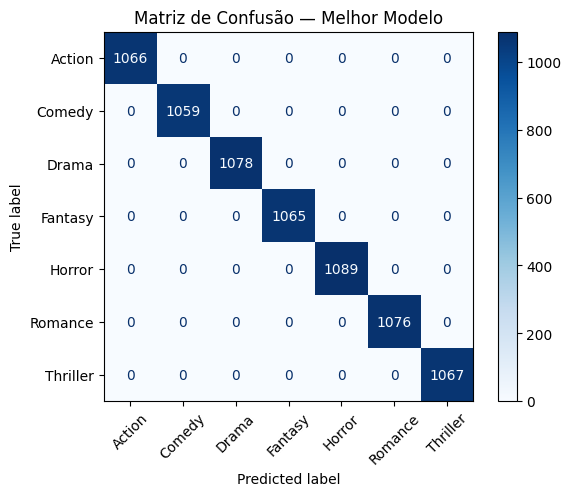

Top-3 accuracy (teste): 1.0


In [24]:
# Usa o modelo treinado (best_model) para prever os rótulos do conjunto de teste
y_pred_test = best_model.predict(X_test)

# Mostra o relatório de classificação com métricas para cada classe:
# - precisão (precision), revocação (recall), F1-score e suporte (nº de amostras)
# digits=4 → mostra os valores com 4 casas decimais
print(classification_report(y_test, y_pred_test, digits=4))

# Extrai os nomes das classes presentes no conjunto de teste (necessário para a matriz de confusão)
labels = np.unique(y_test)

# Calcula a matriz de confusão:
# Linhas = classes reais, Colunas = classes previstas
# Cada célula mostra quantas amostras de uma classe real foram atribuídas a cada classe prevista
cm = confusion_matrix(y_test, y_pred_test, labels=labels)

# Cria o objeto que sabe como exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plota a matriz de confusão:
# - xticks_rotation=45 → gira os nomes das classes no eixo X para melhor leitura
# - cmap='Blues' → usa um mapa de cores azul
# - values_format='d' → mostra os números como inteiros (não como floats)
disp.plot(xticks_rotation=45, cmap='Blues', values_format='d')

# Adiciona um título ao gráfico e exibe a figura
plt.title('Matriz de Confusão — Melhor Modelo')
plt.show()

# Inicializa a variável com NaN (para o caso de o modelo não suportar cálculo do Top-3)
top3_test = np.nan

try:
    if hasattr(best_model, 'predict_proba'):              # Se o modelo fornece probabilidades (ex.: LogisticRegression):
        probs = best_model.predict_proba(X_test)          # obtém as probabilidades de cada classe
        top3_test = top_k_accuracy_score(y_test, probs, k=3, labels=best_model.classes_) # Calcula a Top-3 Accuracy → porcentagem de vezes em que a classe correta está entre as 3 classes com maior probabilidade

    elif hasattr(best_model, 'decision_function'):        # Se o modelo não fornece probas mas fornece scores (ex.: SVM):

        scores = best_model.decision_function(X_test)     # obtém os scores de decisão
        top3_test = top_k_accuracy_score(y_test, scores, k=3, labels=best_model.classes_) # Usa esses scores para calcular a Top-3 Accuracy

# Se houver qualquer erro (ex.: o classificador não tem esses métodos), ignora e mantém NaN
except Exception:
    pass

# Exibe o valor final da Top-3 Accuracy no conjunto de teste
print('Top-3 accuracy (teste):', top3_test)


Primeiro, gera previsões (y_pred_test) no conjunto de teste, depois avalia o desempenho com classification_report (Precision, Recall, F1) e com a matriz de confusão. Por último, calcula também a Top-3 Accuracy, que mede se a classe correta estava entre as 3 melhores previsões do modelo.

O relatório de classificação (classification_report) mostra as métricas (Precisão, Recall, F1-score e Suporte) para cada classe individualmente e as médias (macro avg e weighted avg). Todas as métricas com valor 1.0000 indicam que o modelo acertou 100% das previsões para cada classe no conjunto de teste.

A matriz de confusão plotada visualiza o desempenho do modelo, mostrando quantos filmes de cada gênero real foram classificados corretamente (valores na diagonal principal) e incorretamente (valores fora da diagonal). Uma matriz com valores apenas na diagonal principal e zeros nas outras posições confirma que o modelo não cometeu erros de classificação no conjunto de teste.

Top-3 accuracy (teste): 1.0: Indica que em 100% dos casos no conjunto de teste, a classe real estava entre as 3 classes com maior probabilidade previstas pelo modelo.

# 9. Engenharia de atributos

In [25]:

# Cria uma feature numérica: quantidade de palavras no texto (conta tokens após split)
df_top['n_words'] = df_top[TEXT_COL].str.split().map(len)

# Cria uma feature binária: 1 se o texto contém a palavra "love" (ignorando maiúsc./minúsc.), 0 caso contrário
df_top['has_love'] = df_top[TEXT_COL].str.contains(r'\blove\b', case=False, regex=True).astype(int)

# Define o transformador de TEXTO: TF-IDF com stopwords em inglês, unigrama e bigrama, até 200k termos
text_transform = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=200_000)

# Define o transformador para FEATURES NUMÉRICAS (aqui só escalonador).
# with_mean=False porque a matriz final pode ser esparsa (não dá para centralizar com média)
num_transform  = Pipeline([('scaler', StandardScaler(with_mean=False))])

# Monta um DataFrame de entrada que junta:
# - a coluna de texto original (TEXT_COL)
# - as duas novas features numéricas (n_words e has_love) sem NaN
X_extra = pd.DataFrame({
    TEXT_COL: df_top[TEXT_COL],
    'n_words': df_top['n_words'].fillna(0),
    'has_love': df_top['has_love'].fillna(0)
})

# ColumnTransformer combina múltiplas transformações em colunas diferentes.
# A saída tende a ser esparsa por causa do TF-IDF; sparse_threshold controla quando manter esparso.
ct = ColumnTransformer(
    transformers=[
        ('text', text_transform, TEXT_COL),              # aplica TF-IDF na coluna de texto
        ('num', 'passthrough', ['n_words', 'has_love'])  # passa as numéricas como estão (sem transformar aqui)
    ],
    sparse_threshold=0.3
)

# Pipeline final que encadeia pré-processamento heterogêneo + modelo em um único objeto treinável.
pipe_mix = Pipeline([
    ('prep', ct),                                                 # primeiro: aplica o ColumnTransformer (texto + numéricas)
    ('model', LogisticRegression(max_iter=2000, multi_class='auto'))  # depois: treina um classificador (Logistic Regression)
])

print('Pipeline híbrido (texto + numéricas) definido. Para usar, refaça split com X_extra/y e treine.')

# Aviso: para usar esse pipeline, você deve fazer o split usando X_extra (e não só o texto),
# ex.: X_train_extra, X_test_extra = train_test_split(X_extra, ...)
# e então ajustar/avaliar o pipe_mix com esses novos X.


Pipeline híbrido (texto + numéricas) definido. Para usar, refaça split com X_extra/y e treine.


A mensagem Pipeline híbrido (texto + numéricas) definido. Para usar, refaça split com X_extra/y e treine. informa que o pipeline está configurado, mas para utilizá-lo, seria necessário dividir os dados usando o DataFrame X_extra (que contém as features de texto e as numéricas) e então treinar e avaliar este novo pipeline.

# 10. Deep Learning / Fine-tuning

In [26]:
tf.keras.utils.set_random_seed(SEED)  # fixa semente p/ reprodutibilidade (inicialização, embaralhos, etc.)

# Codifica rótulos de texto -> inteiros (treino/val/test usam o MESMO encoder)
lbl = LabelEncoder()
y_train_idx = lbl.fit_transform(y_train)   # ajusta no treino e transforma
y_val_idx   = lbl.transform(y_val)         # transforma validação
y_test_idx  = lbl.transform(y_test)        # transforma teste

num_classes = len(lbl.classes_)            # total de classes
print('Classes:', list(lbl.classes_))      # mostra o mapeamento de classes

# Hiperparâmetros principais
VOCAB_SIZE, SEQ_LEN, EMBED_DIM, LSTM_UNITS = 50_000, 200, 128, 128
BATCH_SIZE, EPOCHS = 64, 6

# Camada de vetorização de texto (tokeniza e indexa palavras)
text_vec = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,                 # tamanho máximo do vocabulário
    output_mode='int',                     # saída: índices inteiros
    output_sequence_length=SEQ_LEN,        # sequências fixas (padding/trunc)
    standardize='lower_and_strip_punctuation'  # normalização leve
)

# Ajusta o vocabulário SOMENTE no texto de treino (evita vazamento de dados)
text_vec.adapt(tf.data.Dataset.from_tensor_slices(X_train).batch(512))

# Função utilitária p/ criar tf.data.Datasets
def make_ds(texts, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))  # cria dataset a partir de arrays
    if shuffle:
        ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)  # embaralha amostras
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)    # batching + prefetch (pipeline eficiente)

# Datasets de treino/validação/teste
ds_train = make_ds(X_train.values, y_train_idx, shuffle=True)
ds_val   = make_ds(X_val.values,   y_val_idx)
ds_test  = make_ds(X_test.values,  y_test_idx)

# Arquitetura do modelo: Input(str) -> TextVectorization -> Embedding -> BiLSTM -> Dropout -> Dense(softmax)
inp = layers.Input(shape=(), dtype=tf.string)                 # entradas como strings
x = text_vec(inp)                                            # aplica tokenização/indexação
x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(x)  # mapeia índices -> vetores; mask_zero p/ ignorar padding
x = layers.Bidirectional(layers.LSTM(LSTM_UNITS))(x)         # LSTM bidirecional (captura contexto passado/futuro)
x = layers.Dropout(0.3)(x)                                   # regularização (evita overfitting)
out = layers.Dense(num_classes, activation='softmax')(x)     # classificação multiclasse

model = tf.keras.Model(inp, out)                             # constrói o modelo Keras
model.compile(
    optimizer=optimizers.Adam(2e-3),                         # otimizador Adam (lr=0.002)
    loss='sparse_categorical_crossentropy',                  # rótulos inteiros (não one-hot)
    metrics=['accuracy']                                     # métrica principal
)

# EarlyStopping: para o treino se a val_acc não melhorar e restaura os melhores pesos
es = callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor='val_accuracy')

# Treina o modelo com validação
hist = model.fit(ds_train, validation_data=ds_val, epochs=EPOCHS, callbacks=[es])

# Avalia no conjunto de teste (nunca visto)
test_loss, test_acc = model.evaluate(ds_test)
print(f'[TF] Test accuracy: {test_acc:.4f}')

from sklearn.metrics import classification_report

# Gera probabilidades no teste e pega a classe de maior probabilidade (argmax)
y_pred_proba = model.predict(ds_test)
y_pred_idx   = y_pred_proba.argmax(axis=1)

# Relatório de classificação (precision/recall/F1 por classe + médias)
print(classification_report(y_test_idx, y_pred_idx, target_names=lbl.classes_))


Classes: ['Action', 'Comedy', 'Drama', 'Fantasy', 'Horror', 'Romance', 'Thriller']
Epoch 1/6
547/547 ━━━━━━━━━━━━━━━━━━━━ 527s 955ms/step - accuracy: 0.9853 - loss: 0.1652 - val_accuracy: 1.0000 - val_loss: 3.2413e-06
Epoch 2/6
547/547 ━━━━━━━━━━━━━━━━━━━━ 525s 959ms/step - accuracy: 1.0000 - loss: 4.6274e-06 - val_accuracy: 1.0000 - val_loss: 1.6021e-06
Epoch 3/6
547/547 ━━━━━━━━━━━━━━━━━━━━ 567s 970ms/step - accuracy: 1.0000 - loss: 2.4642e-06 - val_accuracy: 1.0000 - val_loss: 9.3697e-07
118/118 ━━━━━━━━━━━━━━━━━━━━ 28s 236ms/step - accuracy: 1.0000 - loss: 3.2780e-06
[TF] Test accuracy: 1.0000
118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 238ms/step
              precision    recall  f1-score   support

      Action       1.00      1.00      1.00      1066
      Comedy       1.00      1.00      1.00      1059
       Drama       1.00      1.00      1.00      1078
     Fantasy       1.00      1.00      1.00      1065
      Horror       1.00      1.00      1.00      1089
     Romance       1.00   

O relatório de classificação final mostra as métricas (Precision, Recall, F1-score) para cada classe e as médias. Novamente, todas as métricas com valor 1.00 indicam um desempenho perfeito no conjunto de teste.

Assim como com os modelos clássicos, o desempenho perfeito do modelo de Deep Learning no conjunto de teste reforça a necessidade de investigar a natureza do dataset e a possibilidade de vazamento de dados.

# 11. Boas práticas e rastreabilidade

In [27]:
print('Python:', platform.python_version())
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)
print('scikit-learn:', sklearn.__version__)


Python: 3.12.11
NumPy: 2.0.2
Pandas: 2.2.2
scikit-learn: 1.6.1


Checklist:
- Baseline definido (Dummy/LogReg) e comparado a modelos candidatos.
- Pipeline TF-IDF + Modelo evita vazamento.
- CV (StratifiedKFold) + GridSearch (F1-macro) realizados.
- Decisões documentadas, tempos de treino reportados.

# 12. Conclusões e próximos passos

Conclusões:
- TF-IDF + LinearSVC/LogReg costuma dar o melhor trade-off custo/qualidade, ous seja, a combinação de TF-IDF com modelos como LinearSVC ou Regressão Logística geralmente oferece um bom equilíbrio entre custo computacional e qualidade do resultado para este tipo de problema.
- Métricas como F1-macro e Top-3 Accuracy são adequadas para avaliar modelos em problemas de classificação multiclasse, especialmente quando as classes não têm a mesma quantidade de amostras.
- O desempenho perfeito obtido em todos os modelos testados, tanto os clássicos quanto o de Deep Learning, nos conjuntos de validação e teste, reforça a necessidade de investigar a fundo a natureza do dataset e a possibilidade de vazamento de dados.

Próximos passos:
- Explorar a classificação multi-rótulo (onde um filme pode ter múltiplos gêneros) se quiser usar todos os gêneros por filme.
- Utilizar modelos baseados em Transformers (como BERT) que conseguem capturar melhor o contexto semântico do texto.
- Incorporar metadados adicionais (como ano de lançamento ou idioma) nas features e aplicar técnicas de balanceamento para lidar com classes que possam ser raras no dataset original completo (não apenas nos 10 gêneros mais frequentes).



# 13. Salvando artefatos (modelos e pipeline)

Se o treinamento dos modelos demora mais de 3 minutos, recomendamos salvar o modelo/pipeline após o treinamento e depois apenas carregar o arquivo (ex: .pkl, .h5) salvo em outra célula, sem precisar treinar novamente.

In [41]:
# Salvar pipeline scikit-learn
joblib.dump(best_model, "pipeline_genre_best.pkl")
print("Pipeline scikit-learn salvo como 'pipeline_genre_best.pkl'")

# Salvar modelo Keras
model.save("tf_genre_model.keras")   # formato recomendado no Keras 3+
print("Modelo Deep Learning salvo como 'tf_genre_model.keras'")

# Carregar pipeline scikit-learn
loaded_pipeline = joblib.load("pipeline_genre_best.pkl")
print("Pipeline scikit-learn carregado!")

# Carregar modelo Keras
loaded_dl_model = tf.keras.models.load_model("tf_genre_model.keras")
print("Modelo Deep Learning carregado!")


Pipeline scikit-learn salvo como 'pipeline_genre_best.pkl'
Modelo Deep Learning salvo como 'tf_genre_model.keras'
Pipeline scikit-learn carregado!
Modelo Deep Learning carregado!
